# IN PROGRESS...

__Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты.__

__На то, как система будет реагировать на определенные жесты - выбор за вами. Например, на определенный жест (жест пис), система будет здороваться с человеком. На другой, будет делать скриншот экрана. И т.д.
Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.__

__*(Усложненное задание) Все тоже самое, но воспользоваться этим датасетом:
https://fitnessallyapp.com/datasets/jester/v1__

In [21]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable

## Подготовка данных

In [22]:
!pip install -q kaggle

from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [23]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                       title                                         size  lastUpdated          downloadCount  
--------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  
manchunhui/us-election-2020-tweets                        US Election 2020 Tweets                      276MB  2020-11-07 12:06:54            624  
unanimad/us-election-2020                                 US Election 2020                             418KB  2020-11-07 19:43:37            445  
headsortails/us-election-2020-presidential-debates        US Election 2020 - Presidential Debates      199MB  2020-10-23 16:56:10            223  
radustoicescu/2020-united-states-presidential-election    2020 United States presidential election      11MB  2019-07-04 15:00:45            550  
etsc9287/2020-general-election-polls                      2020 General Election Polls                  109KB  2020-02-

In [24]:
!mkdir -p HGR/train
!kaggle datasets download -d gti-upm/leapgestrecog
!unzip -qq leapgestrecog.zip -d HGR/
# !rm leapgestrecog.zip

100% 2.12G/2.13G [00:25<00:00, 38.3MB/s]
100% 2.13G/2.13G [00:25<00:00, 89.7MB/s]


In [25]:
dir_root = "./HGR"
dir_files = "/leapGestRecog/"
classes = {key: value[3:] for key, value in zip(range(len(os.listdir(dir_root + dir_files + "00"))), os.listdir(dir_root + dir_files + "00"))}
print(f'Classes: {classes}')

Classes: {0: 'down', 1: 'c', 2: 'ok', 3: 'l', 4: 'palm_moved', 5: 'fist', 6: 'index', 7: 'palm', 8: 'thumb', 9: 'fist_moved'}


In [27]:
for root, dirs, files in os.walk(dir_root + dir_files):
    if files:
        for name in files:
            f = os.path.join(root, name)
            class_name = root.split('_', maxsplit=1)[1]
            try:
                os.mkdir(dir_root + "/train/" + class_name)
            except FileExistsError:
                pass

            os.rename(f, dir_root + '/train/' + class_name + '/' + name)

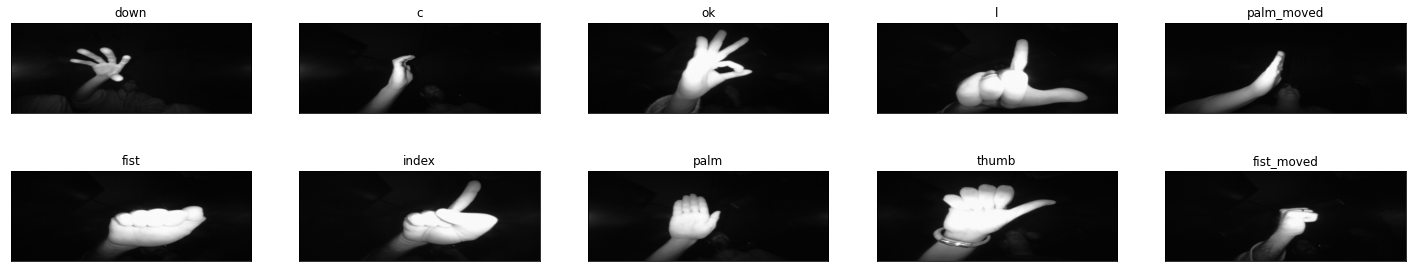

In [28]:
import random
from matplotlib import image

fig = plt.figure(figsize=(25, 5))
for i, class_name in enumerate(classes.values(), start=1):
    path = dir_root + "/train/" + class_name
    ax = fig.add_subplot(2, 5, i)
    img = image.imread(path + "/" + random.choice(os.listdir(path)))
    ax.imshow(img, cmap='gray')
    ax.set_title(class_name)
    plt.xticks([])
    plt.yticks([])

In [29]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [30]:
transforms = tt.Compose([tt.Grayscale(num_output_channels=1), 
                         tt.Resize((128, 128)),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(45),
                         tt.ToTensor()])

In [31]:
gest_dataset = ImageFolder(dir_root + '/train', transforms)

In [32]:
gest_dataset

Dataset ImageFolder
    Number of datapoints: 20000
    Root location: ./HGR/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-45.0, 45.0], resample=False, expand=False)
               ToTensor()
           )

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

In [33]:
batch_size = 32
gest_dataloader = DataLoader(gest_dataset, batch_size, shuffle=True, num_workers=3)
gest_dataloader = DeviceDataLoader(gest_dataloader, device)

In [34]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images.cpu()[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 128, 128])


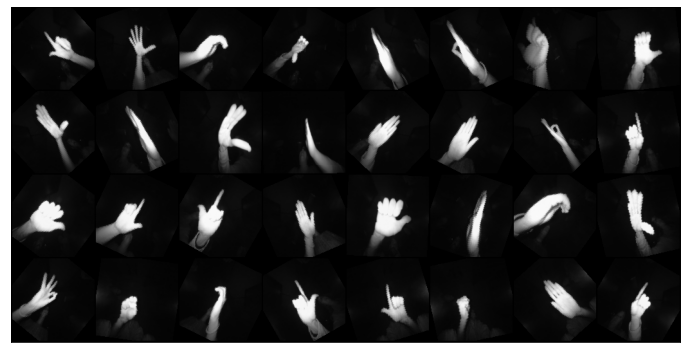

In [35]:
show_batch(gest_dataloader);

## Создание модели

In [36]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 128)
        self.conv2 = self.conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = self.conv_block(128, 256)
        self.conv4 = self.conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(self.conv_block(256, 256), self.conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = self.conv_block(256, 512)
        self.conv6 = self.conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(2048, num_classes))
    
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [37]:
gest_classification = to_device(ResNet(1, len(classes.values())), device)

In [38]:
gest_classification

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

## Обучение

In [20]:
if torch.cuda.is_available(): 
    torch.cuda.empty_cache()

epochs = 50
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(gest_classification.parameters(), max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(gest_dataloader))

In [21]:
total_steps = len(gest_dataloader)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

50 epochs, 625 total_steps per epoch


In [22]:
epoch_losses = []

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(gest_dataloader):
        data, labels = Variable(data), Variable(labels)
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = gest_classification(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 1, loss:  1.046164056658745
Epoch 2, loss:  0.2894955971777439
Epoch 3, loss:  0.28293859543800354
Epoch 4, loss:  0.26036736939609983
Epoch 5, loss:  0.31651488945453893
Epoch 6, loss:  0.27663701525763607
Epoch 7, loss:  0.22235628682168898
Epoch 8, loss:  0.20474341069796356
Epoch 9, loss:  0.19291034115971997
Epoch 10, loss:  0.184566842039302
Epoch 11, loss:  0.1832716289587319
Epoch 12, loss:  0.19705000282861293
Epoch 13, loss:  0.17554715648256242
Epoch 14, loss:  0.1753824185680598
Epoch 15, loss:  0.15976484033633023
Epoch 16, loss:  0.12601817422024905
Epoch 17, loss:  0.11227956748194992
Epoch 18, loss:  0.13242922351397574
Epoch 19, loss:  0.08543260431019589
Epoch 20, loss:  0.11252647848203778
Epoch 21, loss:  0.08792449485496617
Epoch 22, loss:  0.09736727992463858
Epoch 23, loss:  0.0844579737514723
Epoch 24, loss:  0.08337015571347438
Epoch 25, loss:  0.07846042118025943
Epoch 26, loss:  0.05760064725228585
Epoch 27, loss:  0.06683469495598693
Epoch 28, loss:  0

Text(0.5, 1.0, 'losses vs. No. of epochs')

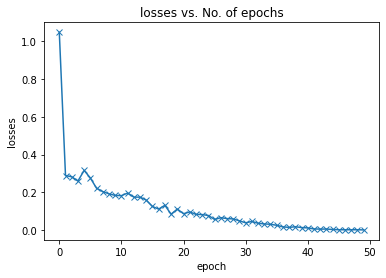

In [23]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

In [24]:
try:
    os.mkdir("./models")
except FileExistsError:
    pass

torch.save(gest_classification.state_dict(), './models/gest_classification_model_state_50_epoch.pth')

In [ ]:
!conda create -n facenet python=3.6 -y
!conda activate facenet
!conda install pytorch==1.4.0 torchvision==0.5.0 cudatoolkit=10.1 -c pytorch -y
!pip install facenet-pytorch

In [ ]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN

# Создаем объект для считывания потока с веб-камеры(обычно вебкамера идет под номером 0. иногда 1)
cap = cv2.VideoCapture(0)


class FaceDetector(object):

    def __init__(self, mtcnn):
        self.mtcnn = mtcnn
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.gmodel = ResNet(1, 10).to(self.device)
        self.gmodel.load_state_dict(torch.load('./models/gest_classification_model_state_50_epoch.pth'))
        self.gmodel.eval()

    # Функция рисования найденных параметров на кадре
    def _draw(self, frame, boxes, probs, gest):
        try:
            for box, prob in zip(boxes, probs):
                # Рисуем обрамляющий прямоугольник лица на кадре
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (0, 0, 255),
                              thickness=2)

                if gest:
                    cv2.putText(frame, 
                        gest, (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                else:
                    cv2.putText(frame, 
                        "Gest not detected", (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

        except:
            return False

        return frame
      
    @staticmethod
    def digit_to_classname(digit):
        return classes[digit]
       
    # Функция в которой будет происходить процесс считывания и обработки каждого кадра
    def run(self):              
        # Заходим в бесконечный цикл
        while True:
            # Считываем каждый новый кадр - frame
            # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
            ret, frame = cap.read()
            try:
                # детектируем расположение лица на кадре, вероятности на сколько это лицо
                boxes, probs = self.mtcnn.detect(frame)
                if probs >= 0.5:
                    try:
                        # Меняем размер изображения для входа в нейронную сеть
                        gest = cv2.resize(frame, (128, 128))
                        # Превращаем в 1-канальное серое изображение
                        gest = cv2.cvtColor(gest, cv2.COLOR_BGR2GRAY)
                        # Превращаем numpy-картинку в pytorch-тензор
                        torch_gest = torch.from_numpy(gest).unsqueeze(0).to(self.device).float()
                        # Загружаем наш тензор в нейронную сеть и получаем предсказание
                        gest = self.gmodel(torch_gest[None, ...])
                        # Интерпретируем предсказание как строку нашего жеста
                        gest = self.digit_to_classname(gest.argmax())
                        # Рисуем на кадре
                        self._draw(frame, boxes, probs, gest)
                        print(7)
                    except:
                        self._draw(frame, boxes, probs, gest=False)

            except:
                print('Something wrong im main cycle!')

            # Показываем кадр в окне, и назвываем его(окно) - 'Face Detection'
            cv2.imshow('Face Detection', frame)
            # Функция, которая проверяет нажатие на клавишу 'q'
            # Если нажатие произошло - выход из цикла. Конец работы приложения
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        # Очищаем все объекты opencv, что мы создали
        cap.release()
        cv2.destroyAllWindows()
        
        
# Загружаем мтцнн
mtcnn = MTCNN(keep_all=True, device=device)
# Создаем объект нашего класса приложения
fcd = FaceDetector(mtcnn)
# Запускаем
fcd.run()

In [ ]:
!conda deactivate
!conda env remove -n facenet